In [2]:
import pandas as pd
import matplotlib.pyplot as plt

from code.utils.settings import DefaultPath

In [3]:
stat_v1_2 = pd.read_csv(
    DefaultPath.data_path.wikitables + 'faiss_stat/v1_2.csv'
)

In [4]:
stat_v1_2.head()

,test_id,n_tables_read,n_row_embeddings,n_column_embeddings,model name,index type,metric,add label,indexing batch size,total concatenate time (s),...,column index write time (s),LUT write time (s),total write time (s),total test time (s),row index size (GB),column index size (GB),LUT size (GB),total size (GB),row batch timestep,column batch timestep
0,0,100,1039,709,ft_cc.en.300_freqprune_400K_100K_pq_300.bin,IndexFlatL2,L2,True,1000,0.06435,...,0.00143,0.00045,0.00407,1.53812,0.00116,0.00079,0.00000,0.00196,"[0.0021448135375976562, 0.0014393329620361328]","[0.001077890396118164, 0.0008404254913330078]"
1,1,100,1039,709,ft_cc.en.300_freqprune_400K_100K_pq_300.bin,IndexFlatL2,L2,True,10000,0.06621,...,0.00139,0.00048,0.00401,1.48185,0.00116,0.00079,0.00000,0.00196,[0.0019071102142333984],[0.0008814334869384766]
2,3,100,1039,709,ft_cc.en.300_freqprune_400K_100K_pq_300.bin,IndexFlatL2,L2,False,1000,0.06103,...,0.00143,0.00048,0.00405,1.42250,0.00116,0.00079,0.00000,0.00196,"[0.001337289810180664, 0.0016481876373291016]","[0.00042700767517089844, 0.00045990943908691406]"
3,4,100,1039,709,ft_cc.en.300_freqprune_400K_100K_pq_300.bin,IndexFlatL2,L2,False,10000,0.06558,...,0.00143,0.00045,0.00408,1.46789,0.00116,0.00079,0.00000,0.00196,[0.0018992424011230469],[0.0008759498596191406]
4,6,250,2889,1776,ft_cc.en.300_freqprune_400K_100K_pq_300.bin,IndexFlatL2,L2,True,1000,0.14207,...,0.00308,0.00108,0.01161,3.83784,0.00323,0.00198,0.00001,0.00522,"[0.0015895366668701172, 0.003412008285522461, ...","[0.0006034374237060547, 0.0015745162963867188,..."


### Analysis: timing

In [25]:
stat_v1_2['concatenate time (%)'] = stat_v1_2['total concatenate time (s)'] / stat_v1_2['total test time (s)']
stat_v1_2['write time (%)'] = stat_v1_2['total write time (s)'] / stat_v1_2['total test time (s)']
stat_v1_2['index time (%)'] = stat_v1_2['total indexing time (s)'] / stat_v1_2['total test time (s)']
stat_v1_2['preindex time (%)'] = stat_v1_2['total preindex time (s)'] / stat_v1_2['total test time (s)']

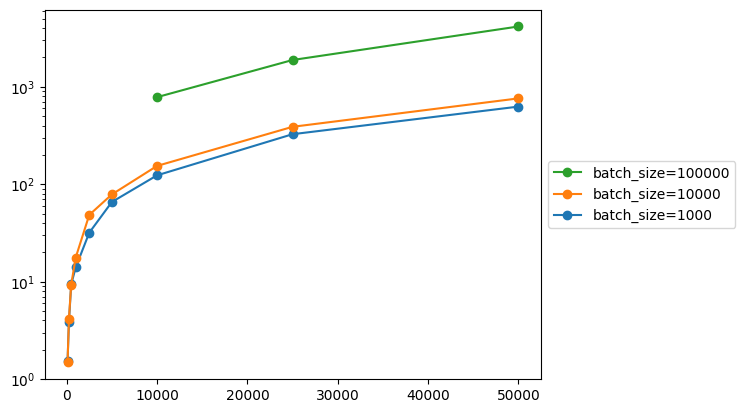

In [24]:
plt.yscale('log')

for batch_size in [1000, 10000, 100000]:
    data = stat_v1_2[(stat_v1_2['add label'] == True) & (stat_v1_2['indexing batch size'] == batch_size)]
    plt.plot(data['n_tables_read'], data['total test time (s)'], 'o-', label=f'batch_size={batch_size}')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), reverse=True)
plt.show()

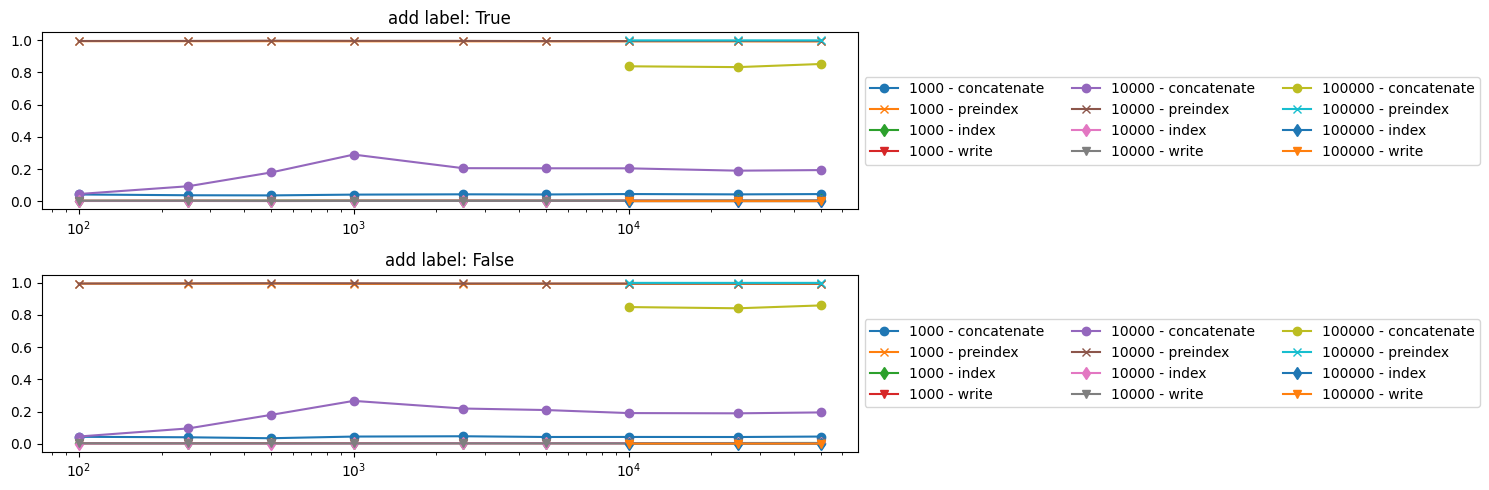

In [40]:
fig, axis = plt.subplots(2, 1, figsize=(15, 5))

for (ax, add_label) in zip(axis, [True, False]):
    for batch_size in [1000, 10000, 100000]:
        ax.set_title(f'add label: {add_label}')
        data = stat_v1_2[(stat_v1_2['add label'] == add_label) & (stat_v1_2['indexing batch size'] == batch_size)]
        # concatenate time is actually a subpart of the preindex step
        ax.plot(data['n_tables_read'], data['concatenate time (%)'],   'o-', label=f'{batch_size} - concatenate')
        ax.plot(data['n_tables_read'], data['preindex time (%)'],      'x-', label=f'{batch_size} - preindex')
        ax.plot(data['n_tables_read'], data['index time (%)'],         'd-', label=f'{batch_size} - index')
        ax.plot(data['n_tables_read'], data['write time (%)'],         'v-', label=f'{batch_size} - write')
        ax.set_xscale('log')
        ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), ncols=3)
fig.tight_layout()
plt.show()

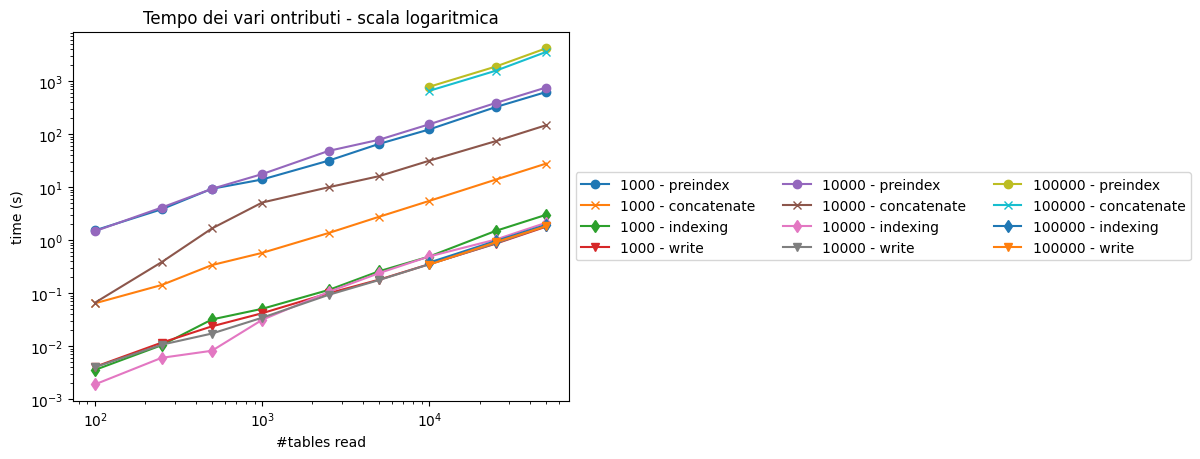

In [47]:
plt.yscale('log')
plt.xscale('log')

for batch_size in [1000, 10000, 100000]:
    data = stat_v1_2[(stat_v1_2['add label'] == True) & (stat_v1_2['indexing batch size'] == batch_size)]
    for (part, symbol) in zip(['preindex', 'concatenate', 'indexing', 'write'], ['o-', 'x-', 'd-', 'v-']):
        plt.plot(data['n_tables_read'], data[f'total {part} time (s)'], symbol, label=f'{batch_size} - {part}')
plt.title('Tempo dei vari ontributi - scala logaritmica')
plt.xlabel('#tables read')
plt.ylabel('time (s)')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), ncols=3)
plt.show()

### Analysis: batch processing

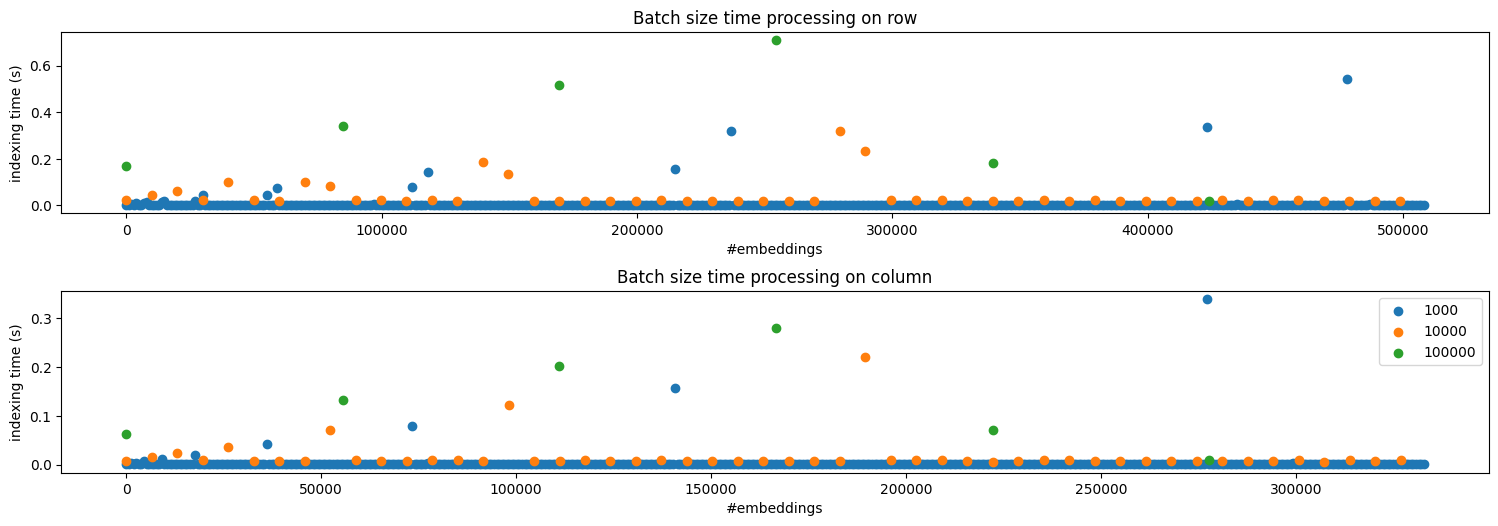

In [148]:
import math

fig, axis = plt.subplots(2, 1, figsize=(15, 5))
fig.tight_layout(h_pad=3.5)

for (ax, item) in zip(axis, ['row', 'column']):
    ax.set_title(f'Batch size time processing on {item}')
    for batch_size in [1000, 10000, 100000]:
        data = stat_v1_2[(stat_v1_2['add label'] == True) & (stat_v1_2['indexing batch size'] == batch_size) & (stat_v1_2['n_tables_read'] == 50000)]
        
        n_embeddings = int(data[f'n_{item}_embeddings'].values[0])
        batch_steps = eval(data[f'{item} batch timestep'].values[0])

        num_batches = len(batch_steps)
        emb_per_batch = math.ceil(n_embeddings / num_batches)
        
        ax.scatter(range(0, emb_per_batch * num_batches, emb_per_batch), batch_steps, label=f'{item} - {batch_size}')
        ax.set_xlabel('#embeddings')
        ax.set_ylabel('indexing time (s)')
plt.legend(['1000', '10000', '100000'])
plt.show()

### Analysis: disk occupancy

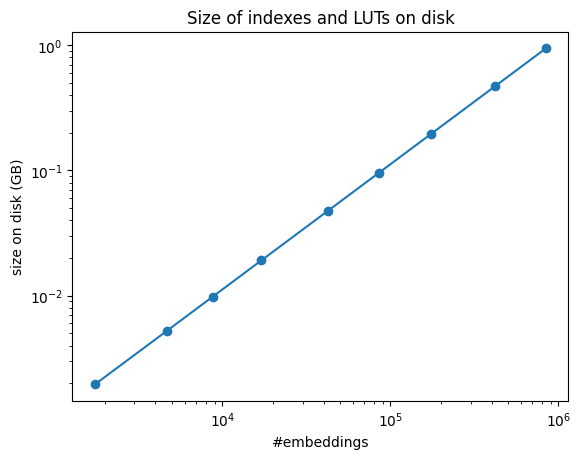

In [153]:
data = stat_v1_2[(stat_v1_2['add label'] == True) & (stat_v1_2['indexing batch size'] == 1000)]
plt.yscale('log')
plt.xscale('log')
plt.plot(data['n_column_embeddings'] + data['n_row_embeddings'], data['total size (GB)'], 'o-')
plt.xlabel('#embeddings')
plt.ylabel('size on disk (GB)')
plt.title('Size of indexes and LUTs on disk')
plt.show()